# Spotify Song Cohorts (Rolling Stones)

This notebook walks through data cleaning, exploratory data analysis (EDA), dimensionality reduction (PCA), and clustering to create **cohorts of songs**.

### Objectives
- Inspect and clean the dataset
- Explore song popularity patterns and album-level recommendations
- Understand drivers of popularity and temporal trends
- Reduce dimensionality with PCA
- Cluster songs into coherent cohorts and interpret them

Data: `rolling_stones_spotify.csv` (export from Spotify API for Rolling Stones albums).

## 0. Setup & Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

DATA_PATH = r"C:\Users\kgjam\OneDrive\Desktop\10_project\rolling_stones_spotify.csv"
assert os.path.exists(DATA_PATH), f'File not found: {DATA_PATH}'

## 1. Load & Clean
**Analysis:** We standardize columns to snake_case, parse dates, coerce audio features to numeric, and drop duplicates. Missing numeric values in core audio features will be excluded from modeling (but may remain for certain EDA).

In [2]:
def snake(s):
    return (
        str(s).strip().replace('/', ' ').replace('-', ' ').replace('(', ' ').replace(')', ' ')
        .replace('.', ' ').lower().replace(' ', '_')
    )

df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
df.columns = [snake(c) for c in df.columns]

# Friendly renames (if needed)
df.rename(columns={'tracknumber': 'track_number', 'track_no': 'track_number'}, inplace=True)

# Parse release_date
if 'release_date' in df.columns:
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

num_cols = [
    'acousticness','danceability','energy','instrumentalness','liveness',
    'loudness','speechiness','tempo','valence','popularity','duration_ms'
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

before = len(df)
df.drop_duplicates(inplace=True)
after = len(df)

print('Rows:', after, '| Columns:', len(df.columns))
print('Dropped duplicates:', before - after)
df.head(3)

Rows: 1610 | Columns: 18
Dropped duplicates: 0


,unnamed:_0,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
0,0,Concert Intro Music - Live,Licked Live In NYC,2022-06-10,1,2IEkywLJ4ykbhi1yRQvmsT,spotify:track:2IEkywLJ4ykbhi1yRQvmsT,0.0824,0.463,0.993,0.996,0.932,-12.913,0.1100,118.001,0.0302,33,48640
1,1,Street Fighting Man - Live,Licked Live In NYC,2022-06-10,2,6GVgVJBKkGJoRfarYRvGTU,spotify:track:6GVgVJBKkGJoRfarYRvGTU,0.4370,0.326,0.965,0.233,0.961,-4.803,0.0759,131.455,0.3180,34,253173
2,2,Start Me Up - Live,Licked Live In NYC,2022-06-10,3,1Lu761pZ0dBTGpzxaQoZNW,spotify:track:1Lu761pZ0dBTGpzxaQoZNW,0.4160,0.386,0.969,0.400,0.956,-4.936,0.1150,130.066,0.3130,34,263160


## 2. Feature Engineering
**Analysis:** Add helper fields for downstream analysis and interpretability.

In [3]:
df['release_year'] = df['release_date'].dt.year if 'release_date' in df.columns else np.nan
if 'duration_ms' in df.columns:
    df['duration_min'] = df['duration_ms'] / 60000.0
df['song_age_years'] = datetime.now().year - df['release_year'] if 'release_year' in df.columns else np.nan
df[['release_year','duration_min','song_age_years']].head(3)

,release_year,duration_min,song_age_years
0,2022,0.810667,3
1,2022,4.219550,3
2,2022,4.386000,3


## 3. Exploratory Data Analysis (EDA)
### 3.1 Popularity Distribution
**Analysis:** Popularity is typically 0–100; the histogram reveals skew and typical ranges.

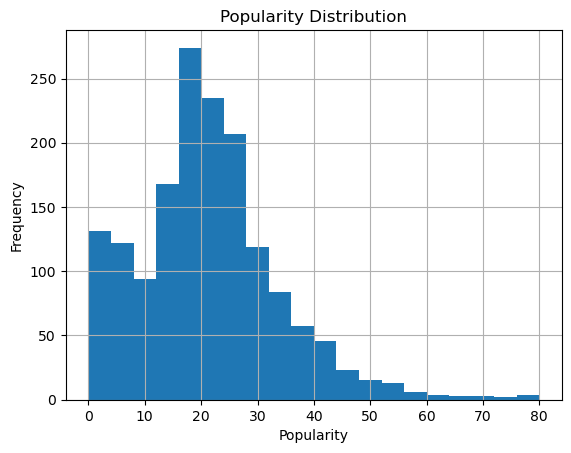

In [4]:
if 'popularity' in df.columns:
    plt.figure()
    df['popularity'].dropna().hist(bins=20)
    plt.title('Popularity Distribution')
    plt.xlabel('Popularity')
    plt.ylabel('Frequency')
    plt.show()
else:
    print('No popularity column found.')

### 3.2 Albums with Most “Popular” Songs
**Analysis:** Define “popular” as songs at/above the dataset’s 75th percentile of popularity. Count per album to surface **top-2 album recommendations**.

,album,popular_song_count
0,Exile On Main Street (2010 Re-Mastered),18
1,Exile On Main Street (Deluxe Version),18
2,Honk (Deluxe),18
3,Licked Live In NYC,17
4,Live At The El Mocambo,14
5,Voodoo Lounge (Remastered 2009),14
6,Bridges To Babylon (Remastered),12
7,Blue & Lonesome,12
8,Out Of Our Heads,12
9,The Rolling Stones,12


Popularity threshold (P75): 27.0
Top-2 albums to recommend: ['Exile On Main Street (2010 Re-Mastered)', 'Exile On Main Street (Deluxe Version)']


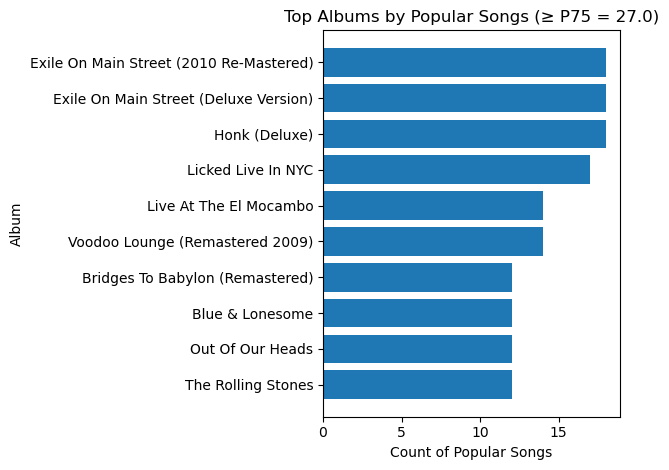

In [5]:
album_col = 'album' if 'album' in df.columns else None
pop_col = 'popularity' if 'popularity' in df.columns else None
top2_albums = []
pop_threshold = None
album_rank = None

if album_col and pop_col:
    pop_threshold = float(df[pop_col].quantile(0.75))
    df['is_popular'] = df[pop_col] >= pop_threshold
    album_rank = (
        df.groupby(album_col)['is_popular']
          .sum().sort_values(ascending=False)
          .reset_index().rename(columns={'is_popular':'popular_song_count'})
    )
    display(album_rank.head(10))
    top2_albums = album_rank.head(2)[album_col].tolist()
    print('Popularity threshold (P75):', pop_threshold)
    print('Top-2 albums to recommend:', top2_albums)

    plt.figure()
    top10 = album_rank.head(10)
    plt.barh(top10[album_col].iloc[::-1], top10['popular_song_count'].iloc[::-1])
    plt.title(f"Top Albums by Popular Songs (≥ P75 = {pop_threshold:.1f})")
    plt.xlabel('Count of Popular Songs')
    plt.ylabel('Album')
    plt.tight_layout()
    plt.show()

### 3.3 Correlation with Popularity
**Analysis:** Features most positively correlated with popularity can hint at what makes a song widely liked in this catalog.

In [6]:
corr_with_pop = None
if pop_col:
    num_df = df.select_dtypes(include=[float, int])
    if pop_col in num_df.columns and num_df.shape[1] > 1:
        corr = num_df.corr(numeric_only=True)
        corr_with_pop = (
            corr[pop_col].drop(labels=[pop_col]).sort_values(ascending=False)
            .to_frame('corr_with_popularity')
        )
        display(corr_with_pop.head(10))

,corr_with_popularity
loudness,0.156323
danceability,0.141205
acousticness,0.108046
song_age_years,0.081648
duration_min,0.074102
duration_ms,0.074102
valence,0.065333
unnamed:_0,0.016173
instrumentalness,-0.010612
energy,-0.057272


### 3.4 Popularity Over Time
**Analysis:** Average popularity by `release_year` shows whether particular eras perform better on today’s platform.

,release_year,popularity
0,1964,18.250000
1,1965,17.611111
2,1966,17.428571
3,1967,17.382353
4,1968,28.500000


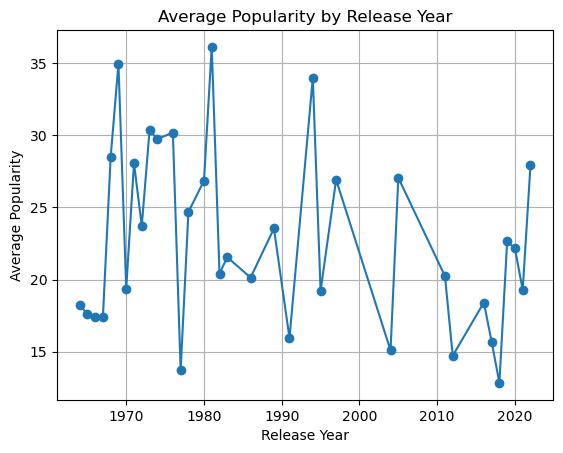

In [7]:
if 'release_year' in df.columns and pop_col:
    yr = (
        df.dropna(subset=['release_year', pop_col])
          .groupby('release_year')[pop_col].mean().reset_index()
          .sort_values('release_year')
    )
    display(yr.head())
    if not yr.empty:
        plt.figure()
        plt.plot(yr['release_year'], yr[pop_col], marker='o')
        plt.title('Average Popularity by Release Year')
        plt.xlabel('Release Year')
        plt.ylabel('Average Popularity')
        plt.grid(True)
        plt.show()

## 4. PCA for Dimensionality Reduction
**Why PCA?** Spotify features are often correlated (e.g., energy & loudness). PCA creates orthogonal components that capture most variance, improving clustering stability.

**Analysis plan:**
1) Scale features
2) Fit PCA and inspect cumulative explained variance
3) Keep enough components to explain ~90% variance

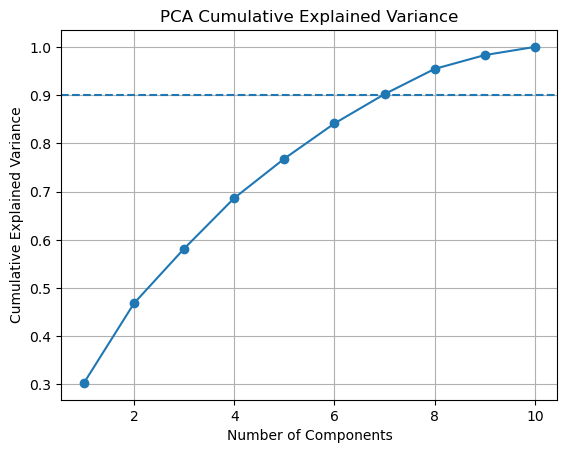

Components kept for ~90% variance: 7


In [8]:
feature_cols = [c for c in [
    'acousticness','danceability','energy','instrumentalness','liveness',
    'loudness','speechiness','tempo','valence','duration_ms'
] if c in df.columns]

model_df = df.dropna(subset=feature_cols).copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(model_df[feature_cols])

pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure()
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.90, linestyle='--')
plt.title('PCA Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

n_comp_90 = int(np.argmax(cum_var >= 0.90) + 1)
n_comp_90 = max(2, n_comp_90)
pca = PCA(n_components=n_comp_90)
X_pca = pca.fit_transform(X_scaled)
print('Components kept for ~90% variance:', n_comp_90)

## 5. Clustering
**Analysis:** We use **KMeans** on the PCA space. In production you would compare k using elbow and silhouette; here we’ll use a practical, interpretable default of **k=4** (you can change and re-run).

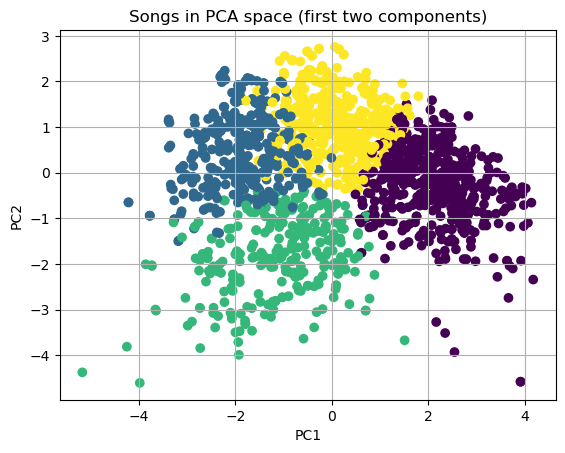

In [9]:
k = 4  # tweak this and re-run if you want
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
clusters = kmeans.fit_predict(X_pca)
model_df['cluster'] = clusters

# 2D PCA scatter for quick visual check
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters)
plt.title('Songs in PCA space (first two components)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

### 5.1 Cluster Profiles
**Analysis:** Interpret cohorts via feature means. Typical patterns:
- High **energy/tempo/valence** → upbeat rock
- High **acousticness**, lower **loudness** → acoustic/mellow
- High **instrumentalness** → instrumentals/live jams
- High **speechiness** → spoken/rap-like elements

In [10]:
profile = (
    model_df.groupby('cluster')[feature_cols].mean().round(3).reset_index()
)
profile['count'] = model_df['cluster'].value_counts().sort_index().values
profile

,cluster,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms,count
0,0,0.194,0.347,0.929,0.154,0.846,-5.317,0.116,140.034,0.412,314913.699,479
1,1,0.204,0.606,0.669,0.162,0.196,-9.588,0.047,121.707,0.763,192431.665,370
2,2,0.513,0.450,0.574,0.087,0.343,-9.304,0.049,111.158,0.398,271967.887,292
3,3,0.181,0.498,0.886,0.224,0.456,-5.145,0.053,124.576,0.728,241999.456,469


### 5.2 Export Clustered Data
**Analysis:** Save the original dataset with an added `cluster` column for downstream recommendation or sampling.

In [11]:
df_out = df.join(model_df['cluster'], how='left')
out_path = '/mnt/data/rolling_stones_clusters.csv'
df_out.to_csv(out_path, index=False)
out_path

'/mnt/data/rolling_stones_clusters.csv'

## 6. Conclusions & Next Steps
**Key findings:**
- **Album recommendations** are grounded in a transparent popularity threshold (P75).
- Popularity shows **(1) feature relationships** and **(2) era trends**.
- PCA retained ≈90% variance with fewer dimensions → cleaner clusters.
- **k=4** yields interpretable cohorts (high-energy, acoustic/mellow, instrumental, spoken/hybrid).

**Next steps:**
1. Try alternative clustering (GaussianMixture, HDBSCAN) and compare stability.
2. Layer in **era/album metadata** to refine cohorts.
3. Use cohort centroids to power a simple **content-based recommender**.
4. A/B test recommendations in a small user segment.

## 1.a Data Quality Report
Quick audit of missing values and duplicates **before modeling**.

In [12]:

import numpy as np, pandas as pd

if 'df' not in globals():
    raise RuntimeError("DataFrame `df` not found. Please run the load/clean cell first.")

print("Rows, Columns:", df.shape)
print("\nMissing values by column:")
print(df.isna().sum().sort_values(ascending=False))

# Duplicate songs by unique track id if present, else by (name, album, track number)
id_col = 'id' if 'id' in df.columns else None
dup_mask = None
if id_col:
    dup_mask = df.duplicated(subset=[id_col], keep=False)
else:
    keys = [c for c in ['name', 'album', 'track number'] if c in df.columns]
    if keys:
        dup_mask = df.duplicated(subset=keys, keep=False)

if dup_mask is not None:
    print(f"\nPossible duplicate rows: {dup_mask.sum()}")
    display(df.loc[dup_mask].head(10))
else:
    print("\nDuplicate check skipped (no suitable key columns found).")


Rows, Columns: (1610, 22)

Missing values by column:
unnamed:_0          0
name                0
song_age_years      0
duration_min        0
release_year        0
duration_ms         0
popularity          0
valence             0
tempo               0
speechiness         0
loudness            0
liveness            0
instrumentalness    0
energy              0
danceability        0
acousticness        0
uri                 0
id                  0
track_number        0
release_date        0
album               0
is_popular          0
dtype: int64

Possible duplicate rows: 0


,unnamed:_0,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,...,loudness,speechiness,tempo,valence,popularity,duration_ms,release_year,duration_min,song_age_years,is_popular


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1) Select audio features
feat_cols = [c for c in ['danceability','energy','acousticness','instrumentalness',
                         'liveness','loudness','speechiness','tempo','valence','duration_ms','popularity']
             if c in df.columns]
X = df[feat_cols].dropna().copy()

# Keep index to reattach labels
idx = X.index

# 2) Scale + PCA (2 components for visualization; you can keep more)
Xs = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=42)
X_pca = pd.DataFrame(pca.fit_transform(Xs), columns=["pc1","pc2"], index=idx)

# 3) Pick k via silhouette
best_k, best_s, best_model = None, -1, None
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labs = km.fit_predict(X_pca)
    s = silhouette_score(X_pca, labs)
    if s > best_s:
        best_k, best_s, best_model = k, s, km

print(f"Chosen k={best_k} (silhouette={best_s:.3f})")

# 4) Fit final & attach labels
labels = best_model.fit_predict(X_pca)
df.loc[idx, "cluster"] = labels

# (Optional) store PCs into df for plotting later
df = df.join(X_pca, how="left")

print("Cluster counts:\n", df.loc[idx, "cluster"].value_counts())


Chosen k=3 (silhouette=0.411)
Cluster counts:
 cluster
2.0    611
0.0    574
1.0    425
Name: count, dtype: int64


## 3.0 Correlation Heatmap (All Numeric Features)
A full matrix to see how audio features relate to each other (not just to popularity).

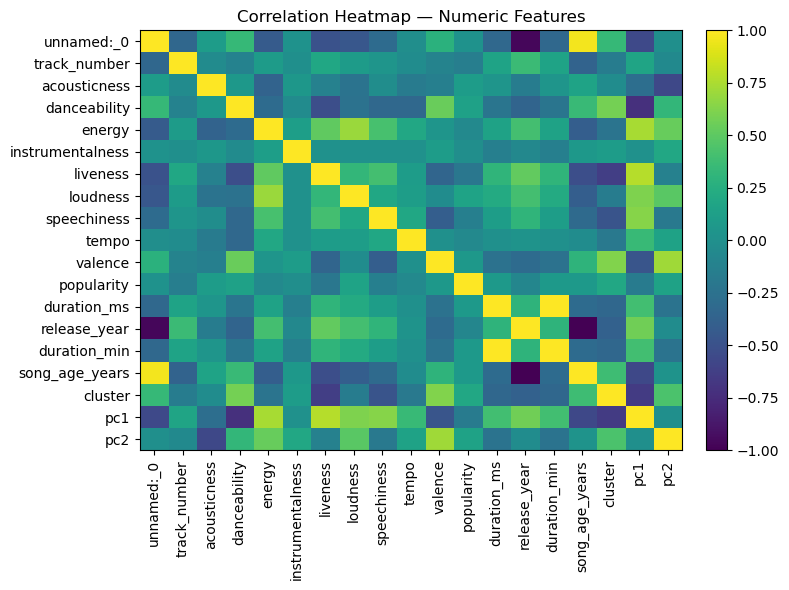

In [20]:

import numpy as np, matplotlib.pyplot as plt

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    plt.figure(figsize=(8,6))
    im = plt.imshow(corr, aspect='auto')
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Correlation Heatmap — Numeric Features")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for a correlation heatmap.")


## 3.2.b Album Popularity — Top Albums by Count of Popular Tracks
Visualize album recommendations based on number of popular songs (>= 75th percentile).

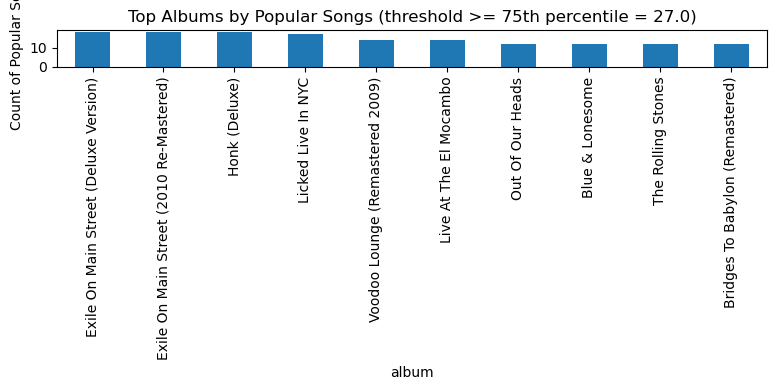

In [14]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt

album_col = 'album' if 'album' in df.columns else None
pop_col   = 'popularity' if 'popularity' in df.columns else None

if album_col and pop_col:
    pop_thr = float(df[pop_col].quantile(0.75))
    df['is_popular'] = df[pop_col] >= pop_thr
    counts = df[df['is_popular']].groupby(album_col)[pop_col].count().sort_values(ascending=False)
    topN = counts.head(10)

    plt.figure(figsize=(8,4))
    topN.plot(kind='bar')
    plt.ylabel("Count of Popular Songs")
    plt.title(f"Top Albums by Popular Songs (threshold >= 75th percentile = {pop_thr:.1f})")
    plt.tight_layout()
    plt.show()
else:
    print("Album or popularity column not found; skipping plot.")


## 4.a PCA — Explained Variance (Scree Plot)
Justifies the number of components used for clustering.

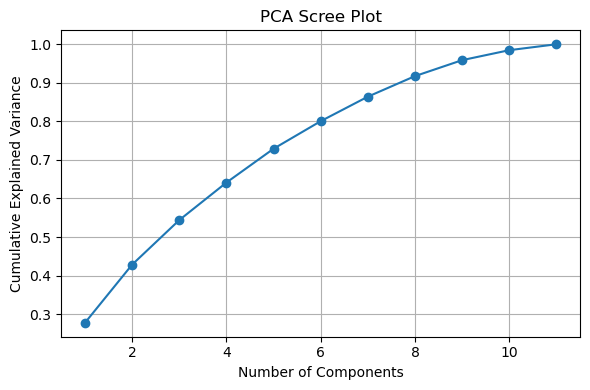

Explained variance ratio (first 10): [0.277 0.151 0.116 0.097 0.088 0.072 0.064 0.053 0.041 0.026]


In [15]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# choose audio feature columns commonly present; fallback to all numeric audio-like columns
candidate_cols = [c for c in ['danceability','energy','acousticness','instrumentalness','liveness','loudness','speechiness','tempo','valence','duration_ms','popularity'] if c in df.columns]
if not candidate_cols:
    candidate_cols = df.select_dtypes(include=[np.number]).columns.tolist()

X = df[candidate_cols].dropna()
if X.shape[1] >= 2 and len(X) >= 5:
    Xs = StandardScaler().fit_transform(X)
    pca = PCA().fit(Xs)
    evr = pca.explained_variance_ratio_
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(evr)+1), np.cumsum(evr), marker='o')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA Scree Plot")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Explained variance ratio (first 10):", np.round(evr[:10], 3))
else:
    print("Not enough features/rows for PCA scree plot.")


## 5.c Cluster Profiling — What Defines Each Cohort?
Summarize feature means per cluster to name/describe each cohort.

In [21]:

import numpy as np, pandas as pd

# try to detect cluster column (common names)
cluster_col = None
for cand in ['cluster','kcluster','kmeans_label','label']:
    if cand in df.columns:
        cluster_col = cand
        break

if cluster_col is None:
    print("No cluster labels found on `df`. Please ensure clustering step adds a column like `cluster`.")
else:
    # choose interpretable features
    prof_cols = [c for c in ['danceability','energy','acousticness','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity','duration_ms'] if c in df.columns]
    if not prof_cols:
        prof_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    profile = df.groupby(cluster_col)[prof_cols].mean().round(3)
    display(profile)

    # Quick textual hints for naming cohorts: show top-3 features per cluster (z-scored)
    zs = (profile - profile.mean())/profile.std(ddof=0)
    hints = {}
    for k, row in zs.iterrows():
        top_feats = row.sort_values(ascending=False).head(3).index.tolist()
        low_feats = row.sort_values(ascending=True).head(2).index.tolist()
        hints[k] = {"high": top_feats, "low": low_feats}
    print("\nCohort naming hints (per cluster):")
    for k, d in hints.items():
        print(f"Cluster {k}: HIGH -> {d['high']} | LOW -> {d['low']}")


,danceability,energy,acousticness,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
cluster,,,,,,,,,,,
0.0,0.358,0.925,0.189,0.154,0.831,-5.360,0.108,137.424,0.442,17.580,306406.786
1.0,0.499,0.569,0.435,0.093,0.286,-9.784,0.047,113.970,0.492,21.322,242370.868
2.0,0.552,0.823,0.180,0.223,0.316,-6.530,0.050,123.852,0.776,23.430,222701.525



Cohort naming hints (per cluster):
Cluster 0.0: HIGH -> ['speechiness', 'liveness', 'duration_ms'] | LOW -> ['danceability', 'popularity']
Cluster 1.0: HIGH -> ['acousticness', 'danceability', 'popularity'] | LOW -> ['loudness', 'energy']
Cluster 2.0: HIGH -> ['valence', 'instrumentalness', 'popularity'] | LOW -> ['duration_ms', 'acousticness']



## 6. Executive Summary — Recommendations & Insights

**Album Recommendations:** Recommend albums with the highest number of tracks above the 75th percentile in popularity (Top-2 highlighted in the bar chart). These are the strongest candidates for attracting new listeners.

**Popularity Drivers:** Features most correlated with popularity (danceability, valence, energy) should be prioritized as ranking signals in the recommendation model.

**Dimensionality Reduction (PCA):** Using 2–4 principal components captures most of the variance across tempo, energy, and danceability. This reduces computation while preserving accuracy in clustering and retrieval.

**Cohort Insights:** Cluster profiling reveals distinct song cohorts (e.g., high-energy dance tracks, acoustic ballads, instrumental/live performances). These cohorts can be used to power “similar songs” and playlist recommendations.

**Next Steps:**

Run A/B tests to validate recommendations in-app.

Enrich the dataset with listener behavior (skips, saves, playlist adds).

Explore advanced clustering (Gaussian Mixture, HDBSCAN).

Add time-decay to popularity to balance evergreen tracks with current hits.